In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras import optimizers

import time 

Using TensorFlow backend.


### Data Processing

In [4]:
df = pd.read_csv('../data/num_data.csv')

In [6]:
POLLUTION = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

In [5]:
WEATHER = ['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']

In [8]:
dataset = df[POLLUTION][:1000]

In [55]:
dataset.shape

(1000, 16)

In [56]:
# Useful functions
def plot_predictions(test, predicted):
    plt.figure(figsize=(30, 15));

    plt.plot(test, color='red', alpha=0.5, label='Actual PM2.5 Concentration',)
    plt.plot(predicted, color='blue', alpha=0.5, label='Predicted PM2.5 Concentation')
    plt.title('PM2.5 Concentration Prediction')
    plt.xlabel('Time')
    plt.ylabel('PM2.5  Concentration')
    plt.legend()
    plt.show()
    

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse

In [57]:
data_size = dataset.shape[0]
train_size=int(data_size * 0.6)
test_size = 100
valid_size = data_size - train_size - test_size

test_next_day = [12, 24, 48]

In [58]:
training_set = dataset[:train_size].iloc[:,4:16].values
valid_set = dataset[train_size:train_size+valid_size].iloc[:,4:16].values
test_set = dataset[data_size-test_size:].iloc[:,4:16].values

In [59]:
y = dataset.iloc[:,4].values
y = y.reshape(-1,1)

y.shape

(1000, 1)

In [60]:
# Scaling the dataset
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
valid_set_scaled = sc.fit_transform(valid_set)
test_set_scaled = sc.fit_transform(test_set)

sc_y = MinMaxScaler(feature_range=(0,1))
y_scaled = sc_y.fit_transform(y)

In [61]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X_, y_ = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1:out_end_ix, 0]
        X_.append(seq_x)
        y_.append(seq_y)
    return np.array(X_), np.array(y_)

In [62]:
n_steps_in = 24
n_steps_out = 24
X_train, y_train = split_sequences(training_set_scaled, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequences(valid_set_scaled, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test_set_scaled, n_steps_in, n_steps_out)

In [63]:
GRU_reg = Sequential()
LSTM_reg = Sequential()
GRU_GRU_reg =  Sequential()
GRU_LSTM_reg = Sequential()
LSTM_GRU_reg = Sequential()
LSTM_LSTM_reg = Sequential()


GRU_reg.add(GRU(units=50, input_shape=(X_train.shape[1],12), activation='tanh'))
# The output layer
GRU_reg.add(Dense(units=n_steps_out))


LSTM_reg.add(LSTM(units=50, input_shape=(X_train.shape[1],12), activation='tanh'))
LSTM_reg.add(Dense(units=n_steps_out))


GRU_GRU_reg.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],12), activation='tanh'))
GRU_GRU_reg.add(GRU(units=50, activation='tanh'))
GRU_GRU_reg.add(Dense(units=n_steps_out))


LSTM_LSTM_reg.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],12), activation='tanh'))
LSTM_LSTM_reg.add(LSTM(units=50, activation='tanh'))
LSTM_LSTM_reg.add(Dense(units=n_steps_out))


LSTM_GRU_reg.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],12), activation='tanh'))
LSTM_GRU_reg.add(GRU(units=50, activation='tanh'))
LSTM_GRU_reg.add(Dense(units=n_steps_out))


GRU_LSTM_reg.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],12), activation='tanh'))
GRU_LSTM_reg.add(LSTM(units=50, activation='tanh'))
GRU_LSTM_reg.add(Dense(units=n_steps_out))


# Compiling the RNNs
adam = optimizers.Adam(lr=0.01)

GRU_reg.compile(optimizer=adam,loss='mean_squared_error')
LSTM_reg.compile(optimizer=adam,loss='mean_squared_error')
GRU_GRU_reg.compile(optimizer=adam,loss='mean_squared_error')
LSTM_LSTM_reg.compile(optimizer=adam,loss='mean_squared_error')
LSTM_GRU_reg.compile(optimizer=adam,loss='mean_squared_error')
GRU_LSTM_reg.compile(optimizer=adam,loss='mean_squared_error')

In [64]:
DFS = Sequential()
CBGRU = Sequential()

DFS_GRU = Sequential()
CBLSTM = Sequential()

DFS_2LSTM = Sequential()
CB_2GRU = Sequential()


# filters defines how many features will be captured
# kernel size gives the size of the sliding window
DFS.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
DFS.add(MaxPooling1D(pool_size=4))
DFS.add(Dropout(0.2))  
DFS.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1],12), activation='tanh'))
DFS.add(Dropout(0.190 + 0.0025 * n_steps_in))
DFS.add(Dense(units=n_steps_out))

CBGRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
CBGRU.add(MaxPooling1D(pool_size=4))
CBGRU.add(Dropout(0.2))  
CBGRU.add(Bidirectional(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1],12), activation='tanh')))
CBGRU.add(Dense(units=n_steps_out))


DFS_GRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
DFS_GRU.add(MaxPooling1D(pool_size=4))
DFS_GRU.add(Dropout(0.2))  
DFS_GRU.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1],12), activation='tanh'))
DFS_GRU.add(Dropout(0.190 + 0.0025 * n_steps_in))
DFS_GRU.add(Dense(units=n_steps_out))

CBLSTM.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
CBLSTM.add(MaxPooling1D(pool_size=4))
CBLSTM.add(Dropout(0.2))  
CBLSTM.add(Bidirectional(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1],12), activation='tanh')))
CBLSTM.add(Dense(units=n_steps_out))


DFS_2LSTM.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
DFS_2LSTM.add(MaxPooling1D(pool_size=4))
DFS_2LSTM.add(Dropout(0.2))  
DFS_2LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],12), activation='tanh'))
DFS_2LSTM.add(LSTM(units=50,  activation='tanh'))
DFS_2LSTM.add(Dropout(0.190 + 0.0025 * n_steps_in))
DFS_2LSTM.add(Dense(units=n_steps_out))

CB_2GRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
CB_2GRU.add(MaxPooling1D(pool_size=4))
CB_2GRU.add(Dropout(0.2))  
CB_2GRU.add(Bidirectional(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],12), activation='tanh')))
CB_2GRU.add(Bidirectional(GRU(units=50, activation='tanh')))
CB_2GRU.add(Dense(units=n_steps_out))



# Compiling the RNNs
adam = optimizers.Adam(lr=0.01)

DFS.compile(optimizer=adam,loss='mean_squared_error')
CBGRU.compile(optimizer=adam,loss='mean_squared_error')
DFS_2LSTM.compile(optimizer=adam,loss='mean_squared_error')
CBLSTM.compile(optimizer=adam,loss='mean_squared_error')
DFS_GRU.compile(optimizer=adam,loss='mean_squared_error')
CB_2GRU.compile(optimizer=adam,loss='mean_squared_error')

In [66]:
RnnModelDict = {'LSTM': LSTM_reg, 'GRU': GRU_reg, 'LSTM_LSTM': LSTM_LSTM_reg, 'GRU_GRU': GRU_GRU_reg, 
                'LSTM_GRU': LSTM_GRU_reg, 'GRU_LSTM': GRU_LSTM_reg, 'DFS': DFS, 'CBGRU': CBGRU,
                'DFS_GRU': DFS_GRU, 'DFS_2LSTM': DFS_2LSTM, 'CB_2GRU': CB_2GRU, 'CBLSTM': CBLSTM}

X_test_24 = X_test[:24]
y_test_24 = y_test[:24]
rmse_df = pd.DataFrame(columns=['Model', 'train_rmse', 'valid_rmse', '24h_pred_rmse', 'train_time', ])

RnnModelDict = {'LSTM_GRU': LSTM_GRU_reg}

training start for LSTM_GRU
Epoch 1/2
566/566 [==============================] - 2s 3ms/step - loss: 0.0362
Epoch 2/2
566/566 [==============================] - 0s 493us/step - loss: 0.0180
results for training set


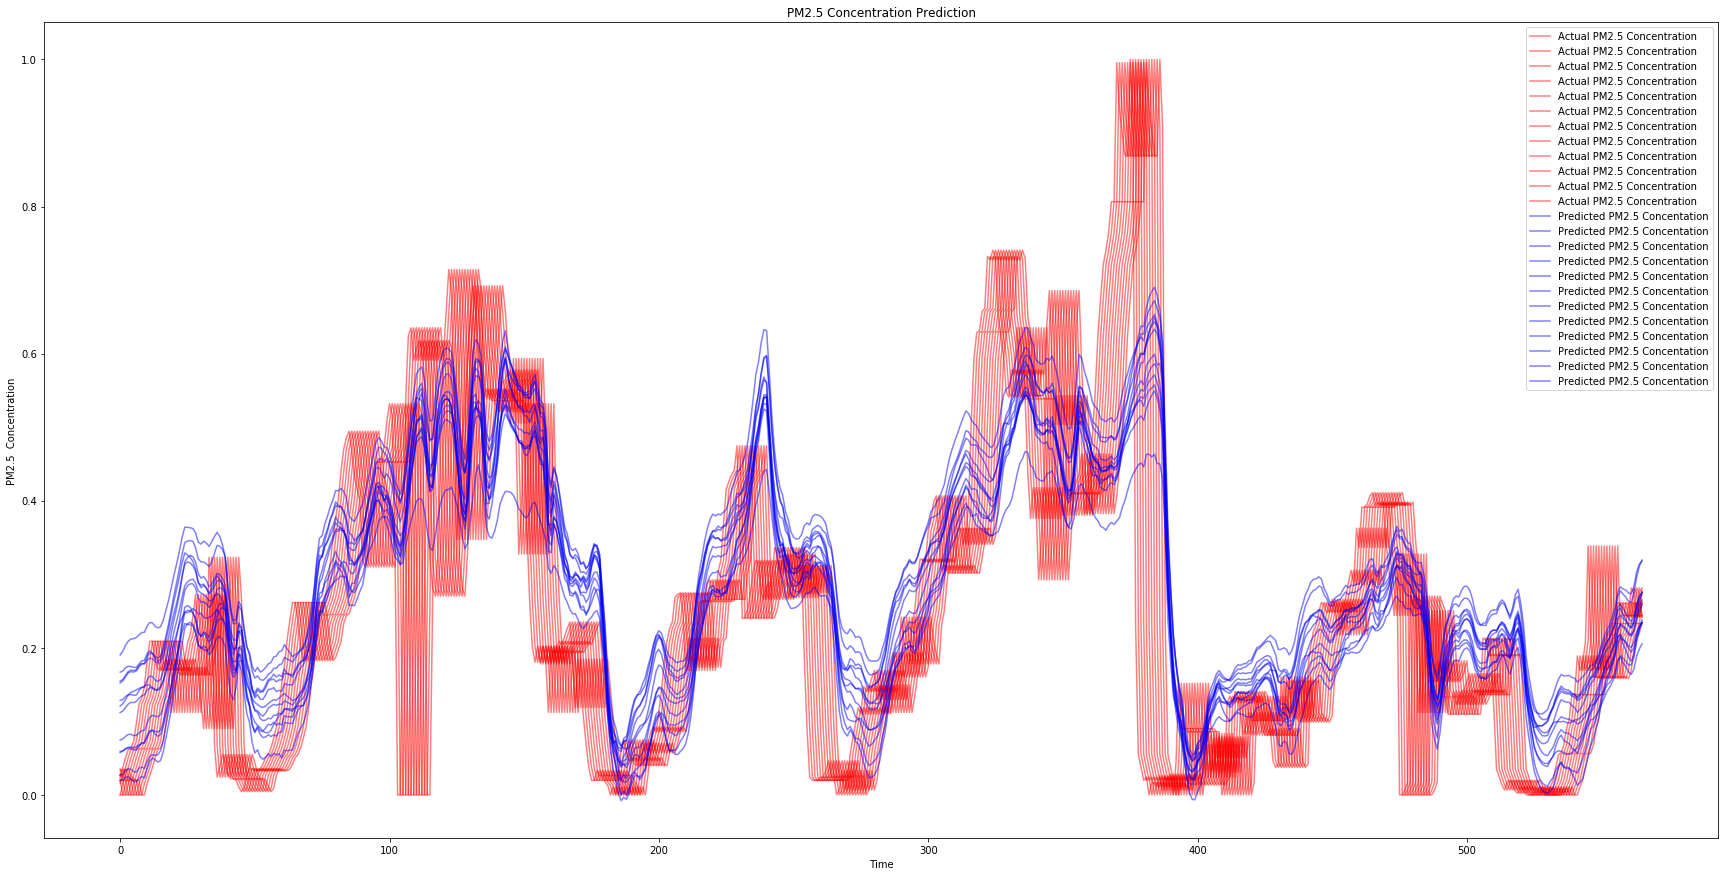

results for valid set


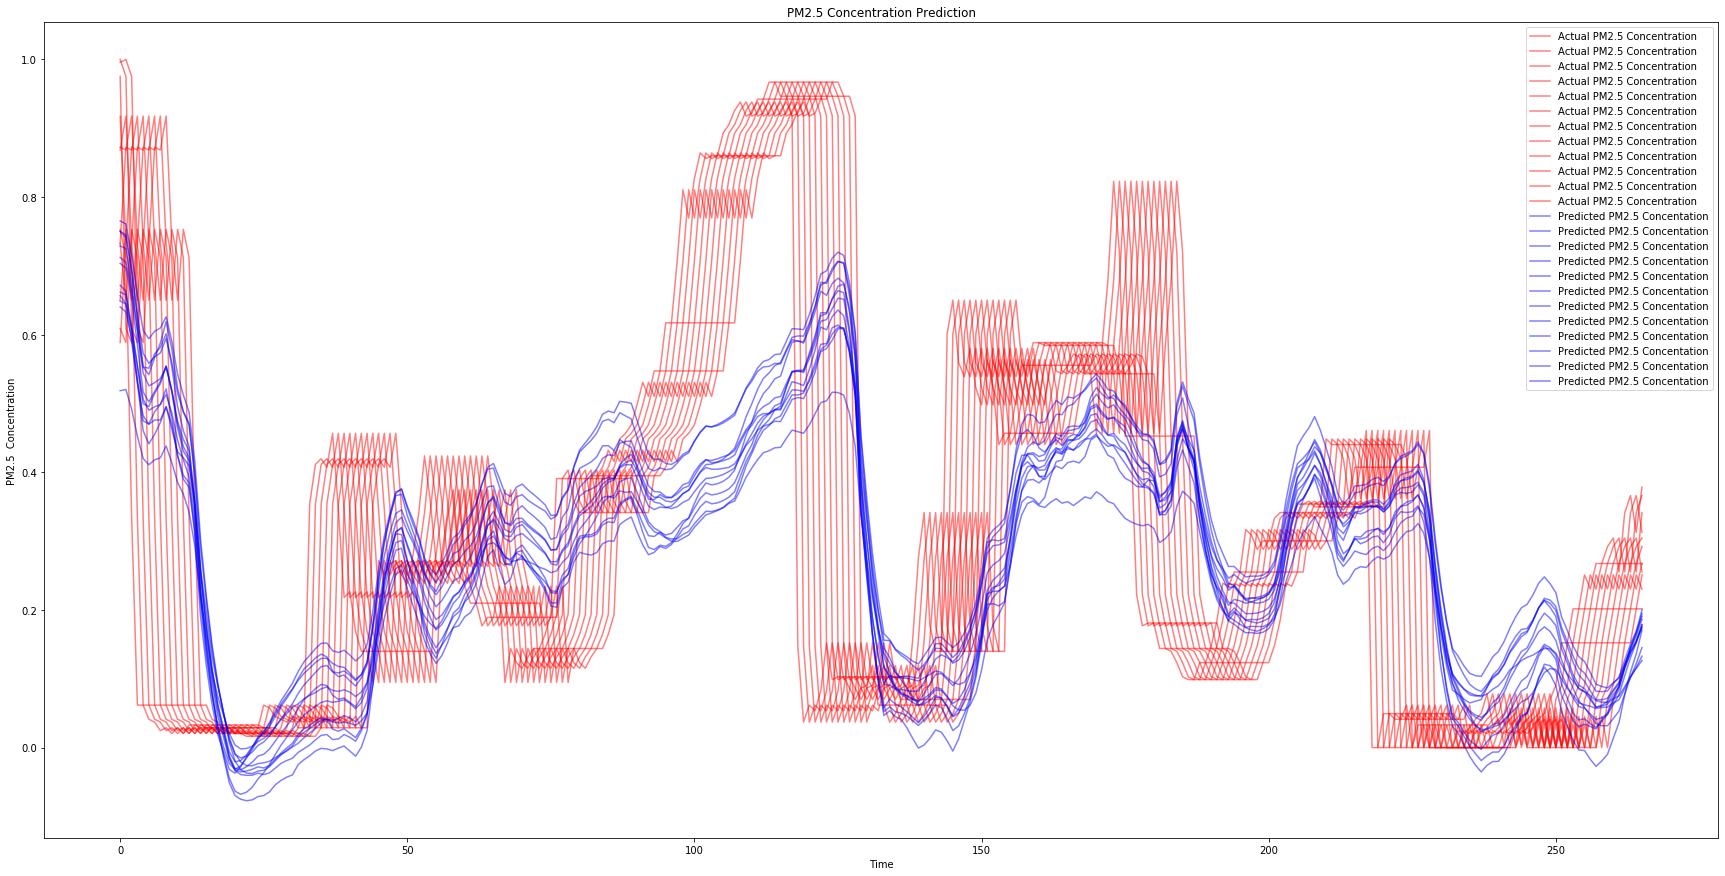

results for test set - 24 hours


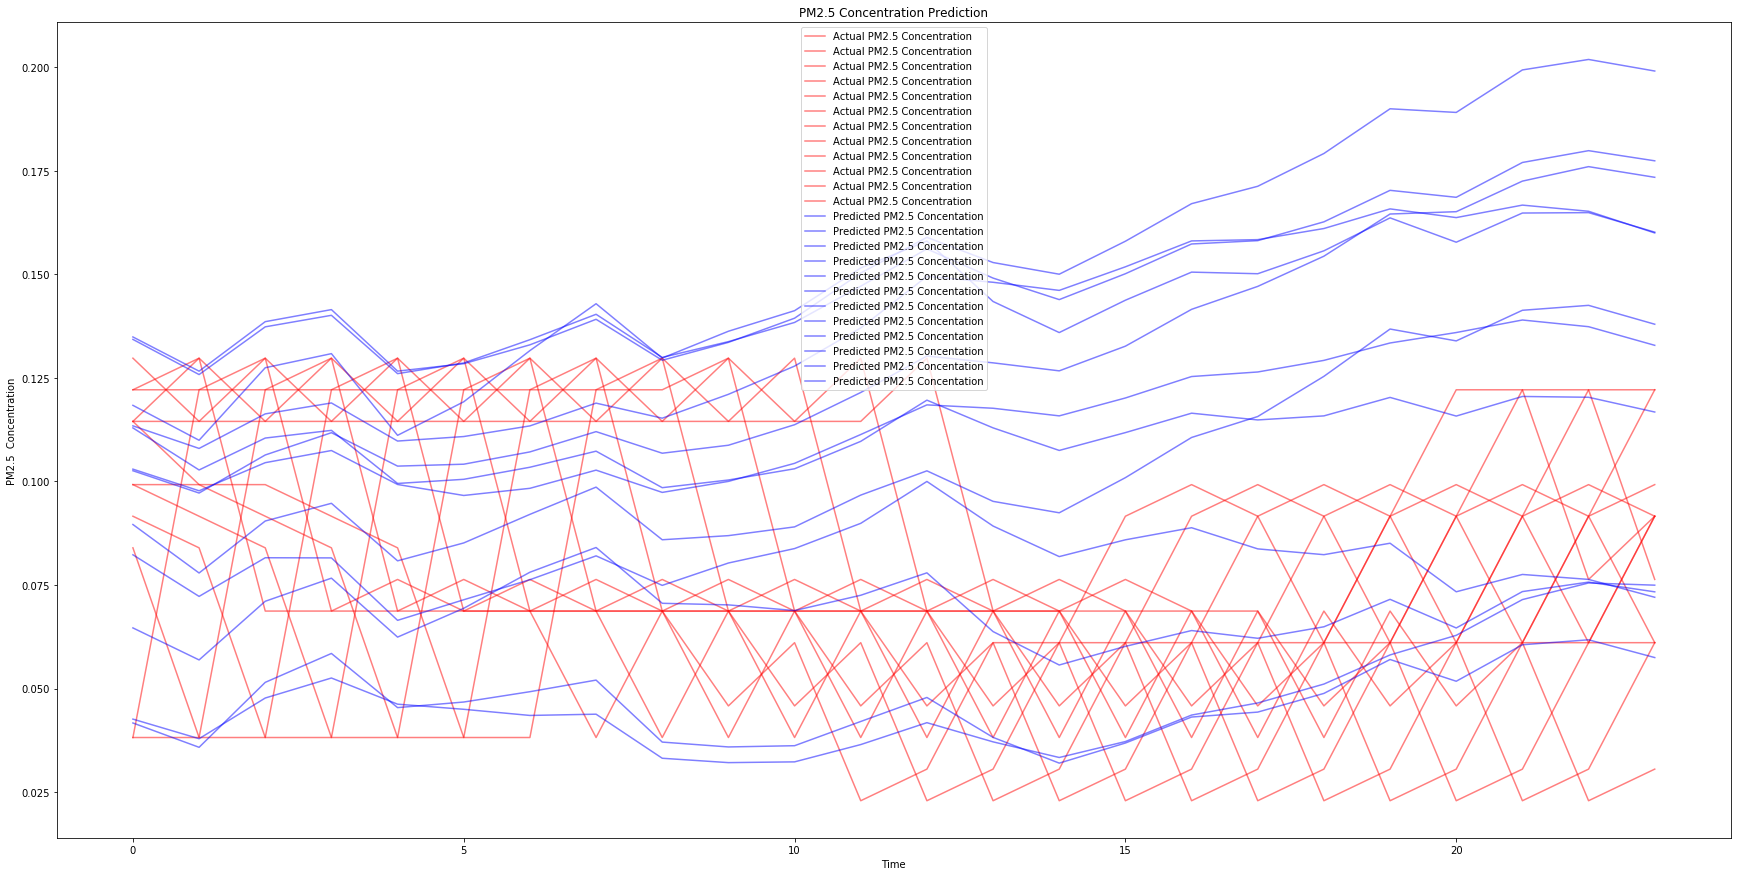

In [67]:
for model in RnnModelDict:
    regressor = RnnModelDict[model]
    
    print('training start for', model)    
    start = time.process_time()
    regressor.fit(X_train,y_train,epochs=2,batch_size=32)
    train_time = round(time.process_time() - start, 2)
    
    print('results for training set')
    y_train_pred = regressor.predict(X_train)
    plot_predictions(y_train,y_train_pred)
    train_rmse = return_rmse(y_train,y_train_pred)
    
    print('results for valid set')
    y_valid_pred = regressor.predict(X_valid)
    plot_predictions(y_valid,y_valid_pred)
    valid_rmse = return_rmse(y_valid,y_valid_pred)
    
    
    print('results for test set - 24 hours')
    y_test_pred24 = regressor.predict(X_test_24)
    plot_predictions(y_test_24,y_test_pred24)
    test24_rmse = return_rmse(y_test_24,y_test_pred24)
    
    
    one_df = pd.DataFrame([[model, train_rmse, valid_rmse, test24_rmse, train_time]], 
                          columns=['Model', 'train_rmse', 'valid_rmse', '24h_pred_rmse', 'train_time'])
    rmse_df = pd.concat([rmse_df, one_df])

# save the rmse results 
rmse_df.to_csv('../rmse_result_all_v1.csv')


Train on 566 samples, validate on 266 samples
Epoch 1/500
 - 0s - loss: 0.0041 - val_loss: 0.0399
Epoch 2/500
 - 0s - loss: 0.0069 - val_loss: 0.0388
Epoch 3/500
 - 0s - loss: 0.0070 - val_loss: 0.0439
Epoch 4/500
 - 0s - loss: 0.0078 - val_loss: 0.0370
Epoch 5/500
 - 0s - loss: 0.0074 - val_loss: 0.0394
Epoch 6/500
 - 0s - loss: 0.0045 - val_loss: 0.0380
Epoch 7/500
 - 0s - loss: 0.0060 - val_loss: 0.0392
Epoch 8/500
 - 0s - loss: 0.0042 - val_loss: 0.0494
Epoch 9/500
 - 0s - loss: 0.0087 - val_loss: 0.0498
Epoch 10/500
 - 0s - loss: 0.0051 - val_loss: 0.0378
Epoch 11/500
 - 0s - loss: 0.0044 - val_loss: 0.0366
Epoch 12/500
 - 0s - loss: 0.0035 - val_loss: 0.0474
Epoch 13/500
 - 0s - loss: 0.0042 - val_loss: 0.0385
Epoch 14/500
 - 0s - loss: 0.0030 - val_loss: 0.0345
Epoch 15/500
 - 0s - loss: 0.0031 - val_loss: 0.0373
Epoch 16/500
 - 0s - loss: 0.0028 - val_loss: 0.0378
Epoch 17/500
 - 0s - loss: 0.0023 - val_loss: 0.0375
Epoch 18/500
 - 0s - loss: 0.0029 - val_loss: 0.0338
Epoch 19/

 - 0s - loss: 9.9264e-04 - val_loss: 0.0503
Epoch 154/500
 - 0s - loss: 8.2185e-04 - val_loss: 0.0511
Epoch 155/500
 - 0s - loss: 7.8083e-04 - val_loss: 0.0506
Epoch 156/500
 - 0s - loss: 7.1083e-04 - val_loss: 0.0512
Epoch 157/500
 - 0s - loss: 7.2504e-04 - val_loss: 0.0507
Epoch 158/500
 - 0s - loss: 7.5179e-04 - val_loss: 0.0520
Epoch 159/500
 - 0s - loss: 7.8324e-04 - val_loss: 0.0501
Epoch 160/500
 - 0s - loss: 7.2553e-04 - val_loss: 0.0521
Epoch 161/500
 - 0s - loss: 7.5833e-04 - val_loss: 0.0500
Epoch 162/500
 - 0s - loss: 7.9967e-04 - val_loss: 0.0504
Epoch 163/500
 - 0s - loss: 8.1914e-04 - val_loss: 0.0512
Epoch 164/500
 - 0s - loss: 0.0010 - val_loss: 0.0494
Epoch 165/500
 - 0s - loss: 0.0012 - val_loss: 0.0502
Epoch 166/500
 - 0s - loss: 9.8867e-04 - val_loss: 0.0519
Epoch 167/500
 - 0s - loss: 0.0010 - val_loss: 0.0510
Epoch 168/500
 - 0s - loss: 9.1774e-04 - val_loss: 0.0516
Epoch 169/500
 - 0s - loss: 7.5191e-04 - val_loss: 0.0517
Epoch 170/500
 - 0s - loss: 9.6808e-04 -

Epoch 300/500
 - 0s - loss: 0.0012 - val_loss: 0.0416
Epoch 301/500
 - 0s - loss: 0.0015 - val_loss: 0.0439
Epoch 302/500
 - 0s - loss: 0.0019 - val_loss: 0.0441
Epoch 303/500
 - 0s - loss: 0.0030 - val_loss: 0.0594
Epoch 304/500
 - 0s - loss: 0.0034 - val_loss: 0.0441
Epoch 305/500
 - 0s - loss: 0.0039 - val_loss: 0.0449
Epoch 306/500
 - 0s - loss: 0.0029 - val_loss: 0.0448
Epoch 307/500
 - 0s - loss: 0.0041 - val_loss: 0.0432
Epoch 308/500
 - 0s - loss: 0.0028 - val_loss: 0.0500
Epoch 309/500
 - 0s - loss: 0.0019 - val_loss: 0.0465
Epoch 310/500
 - 0s - loss: 0.0022 - val_loss: 0.0510
Epoch 311/500
 - 0s - loss: 0.0015 - val_loss: 0.0436
Epoch 312/500
 - 0s - loss: 0.0021 - val_loss: 0.0440
Epoch 313/500
 - 0s - loss: 0.0015 - val_loss: 0.0439
Epoch 314/500
 - 0s - loss: 0.0015 - val_loss: 0.0492
Epoch 315/500
 - 0s - loss: 0.0014 - val_loss: 0.0504
Epoch 316/500
 - 0s - loss: 0.0012 - val_loss: 0.0453
Epoch 317/500
 - 0s - loss: 0.0010 - val_loss: 0.0444
Epoch 318/500
 - 0s - loss: 

Epoch 446/500
 - 0s - loss: 0.0012 - val_loss: 0.0486
Epoch 447/500
 - 0s - loss: 9.5112e-04 - val_loss: 0.0452
Epoch 448/500
 - 0s - loss: 0.0011 - val_loss: 0.0488
Epoch 449/500
 - 0s - loss: 0.0012 - val_loss: 0.0494
Epoch 450/500
 - 0s - loss: 9.4894e-04 - val_loss: 0.0500
Epoch 451/500
 - 0s - loss: 8.4521e-04 - val_loss: 0.0465
Epoch 452/500
 - 0s - loss: 9.1991e-04 - val_loss: 0.0439
Epoch 453/500
 - 0s - loss: 0.0011 - val_loss: 0.0484
Epoch 454/500
 - 0s - loss: 0.0012 - val_loss: 0.0505
Epoch 455/500
 - 0s - loss: 0.0010 - val_loss: 0.0475
Epoch 456/500
 - 0s - loss: 0.0013 - val_loss: 0.0488
Epoch 457/500
 - 0s - loss: 9.7346e-04 - val_loss: 0.0439
Epoch 458/500
 - 0s - loss: 9.5814e-04 - val_loss: 0.0495
Epoch 459/500
 - 0s - loss: 8.9520e-04 - val_loss: 0.0485
Epoch 460/500
 - 0s - loss: 0.0017 - val_loss: 0.0536
Epoch 461/500
 - 0s - loss: 0.0015 - val_loss: 0.0470
Epoch 462/500
 - 0s - loss: 0.0018 - val_loss: 0.0459
Epoch 463/500
 - 0s - loss: 0.0020 - val_loss: 0.0497


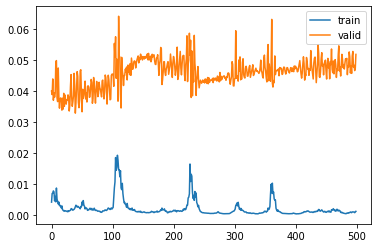

In [93]:
history = regressor.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_valid, y_valid),
                        verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [80]:
# Transform back and plot
y_train_origin = y_train
y_train_origin = sc_y.inverse_transform(y_train_origin)

y_train_pred = regressor.predict(X_train)
y_train_pred_origin = sc_y.inverse_transform(y_train_pred)

plot_predictions(y_train_origin,y_train_pred_origin)
return_rmse(y_train_origin,y_train_pred_origin)